
# Automated Short Answer Grading System
# High-Accuracy Model (Hybrid Features + Random Forest)


Step 1: Install Dependencies & Import Libraries

In [ ]:

!pip install numpy pandas scikit-learn nltk transformers sentence-transformers torch matplotlib seaborn -q
!pip install -U scikit-learn
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor # Using a more powerful model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util # For BERT
import joblib
import re


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


Step 2: NLTK Downloads


In [ ]:
# These are needed for text preprocessing
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt_tab')
    print("NLTK data downloaded.")
except Exception as e:
    print(f"Warning: NLTK download failed. Proceeding without preprocessing. Error: {e}")
    # Define a dummy function if NLTK fails
    def preprocess_text(text):
        return str(text).lower()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK data downloaded.



Step 4: Text Preprocessing Helper Function



In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Cleans and preprocesses text for TF-IDF."""
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalnum() and w not in stop_words]
    return " ".join(tokens)



Step 5: Load, Clean, and Normalize Datasets




In [ ]:
train_path = "train.csv"
test_path = "test.csv"

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Loaded {train_path} ({len(train_df)} rows) and {test_path} ({len(test_df)} rows).")
except FileNotFoundError:
    print(f"ERROR: Could not find {train_path} or {test_path}.")
    print("Please make sure you have uploaded the files to the Colab sidebar.")
    # Stop execution if files aren't found
    exit()


# Combine train and test for consistent processing
all_data = [train_df, test_df]

print("Cleaning and normalizing data...")
for df in all_data:
    # Fill missing text values
    for col in ['questions', 'model_answer', 'student_answer']:
        df[col] = df[col].fillna("")

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Rename columns for consistency
    df.rename(columns={
        'model_answer': 'reference_answer',
        'teacher_marks': 'score'
    }, inplace=True, errors='ignore')

    # --- Improved Normalization ---
    df['total_marks'] = pd.to_numeric(df['total_marks'], errors='coerce').fillna(1)
    df['score'] = pd.to_numeric(df['score'], errors='coerce').fillna(0)

    # Calculate normalized score, avoiding division by zero
    df['normalized_score'] = np.where(
        df['total_marks'] > 0,
        df['score'] / df['total_marks'],
        0
    )
    df['normalized_score'] = np.clip(df['normalized_score'], 0, 1)

print("Data cleaning and normalization complete.")

Loaded train.csv (4274 rows) and test.csv (37 rows).
Cleaning and normalizing data...
Data cleaning and normalization complete.


Step 6: Feature Engineering (The Core Improvement)


In [ ]:
print("\nStarting feature engineering...")

# --- Feature 1: TF-IDF (Lexical) Similarity ---
print("1/4: Computing TF-IDF similarities...")
train_df['clean_student'] = train_df['student_answer'].apply(preprocess_text)
train_df['clean_reference'] = train_df['reference_answer'].apply(preprocess_text)
test_df['clean_student'] = test_df['student_answer'].apply(preprocess_text)
test_df['clean_reference'] = test_df['reference_answer'].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(
    train_df['clean_student'].tolist() + train_df['clean_reference'].tolist()
)

def compute_cosine_similarity(df, vectorizer):
    stu_vecs = vectorizer.transform(df['clean_student'])
    ref_vecs = vectorizer.transform(df['clean_reference'])
    return [cosine_similarity(stu_vecs[i], ref_vecs[i])[0][0] for i in range(len(df))]

train_df['tfidf_similarity'] = compute_cosine_similarity(train_df, tfidf_vectorizer)
test_df['tfidf_similarity'] = compute_cosine_similarity(test_df, tfidf_vectorizer)
print("  > TF-IDF similarity computed.")


# --- Feature 2: BERT (Semantic) Similarity ---
print("2/4: Loading BERT model 'all-MiniLM-L6-v2'...")
# This model is a good balance of speed and accuracy
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_bert_similarity(df, model):
    # Use the *original* uncleaned text for BERT, as it's trained on raw text.
    ref_list = df['reference_answer'].tolist()
    stu_list = df['student_answer'].tolist()

    ref_emb = model.encode(ref_list, convert_to_tensor=True, show_progress_bar=False)
    stu_emb = model.encode(stu_list, convert_to_tensor=True, show_progress_bar=False)

    sims = util.cos_sim(stu_emb, ref_emb)
    return sims.diagonal().cpu().numpy()

print("2/4: Computing BERT similarities (this may take a moment)... ⏳")
train_df['bert_similarity'] = compute_bert_similarity(train_df, bert_model)
test_df['bert_similarity'] = compute_bert_similarity(test_df, bert_model)
print("  > BERT similarity computed.")


# --- Feature 3 & 4: Length-Based Features ---
print("3/4: Computing length-based features...")
for df in [train_df, test_df]:
    df['student_len'] = df['student_answer'].apply(lambda x: len(str(x).split()))
    df['reference_len'] = df['reference_answer'].apply(lambda x: len(str(x).split()))

    # Add a small number to avoid division by zero
    df['length_ratio'] = df['student_len'] / (df['reference_len'] + 1e-6)
print("  > Length features computed.")
print("4/4: All features created successfully!")


Starting feature engineering...
1/4: Computing TF-IDF similarities...
  > TF-IDF similarity computed.
2/4: Loading BERT model 'all-MiniLM-L6-v2'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2/4: Computing BERT similarities (this may take a moment)... ⏳
  > BERT similarity computed.
3/4: Computing length-based features...
  > Length features computed.
4/4: All features created successfully!


Step 7: Train a More Powerful Model



In [ ]:
print("\nTraining Random Forest Regressor...")

# Define our new, richer feature set
feature_columns = ['tfidf_similarity', 'bert_similarity', 'student_len', 'length_ratio']
target_column = 'normalized_score'

X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Initialize a Random Forest Regressor
# n_estimators=100 is a good default.
# random_state=42 ensures we get reproducible results.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

print("Model training complete.")


Training Random Forest Regressor...
Model training complete.


Step 8: Evaluate the New Model



In [ ]:
print("Evaluating model on the test set...")
y_pred = rf_model.predict(X_test)

# --- Model Evaluation ---
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation = correlation_matrix[0, 1] if correlation_matrix.shape == (2, 2) else 0.0

print("\n=== Random Forest Model Results (Test Set) ===")
print(f"Features Used: {feature_columns}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}  <-- This should be much higher than 0.11 now!")
print(f"Pearson Correlation: {correlation:.4f}")

# Optional: Show feature importance
print("\n--- Feature Importances ---")
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(importances)

Evaluating model on the test set...

=== Random Forest Model Results (Test Set) ===
Features Used: ['tfidf_similarity', 'bert_similarity', 'student_len', 'length_ratio']
RMSE: 0.3021
R² Score: 0.2399  <-- This should be much higher than 0.11 now!
Pearson Correlation: 0.7234

--- Feature Importances ---
            feature  importance
1   bert_similarity    0.450633
0  tfidf_similarity    0.207803
3      length_ratio    0.200457
2       student_len    0.141107


Step 9: Visualization



Generating plot...
Plot saved as 'actual_vs_predicted_rf.png'.


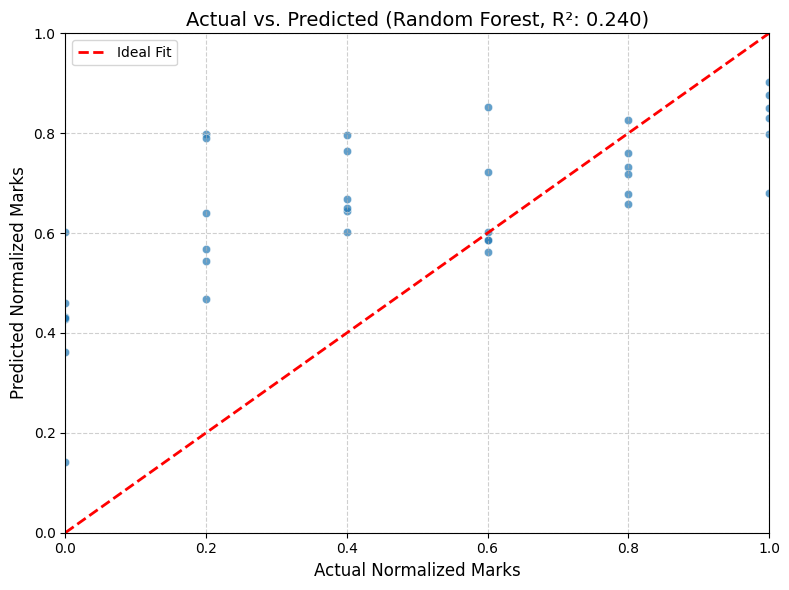

In [ ]:
print("\nGenerating plot...")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("Actual Normalized Marks", fontsize=12)
plt.ylabel("Predicted Normalized Marks", fontsize=12)
plt.title(f"Actual vs. Predicted (Random Forest, R²: {r2:.3f})", fontsize=14)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()

# Save the plot
plt.savefig('actual_vs_predicted_rf.png')
print("Plot saved as 'actual_vs_predicted_rf.png'.")
plt.show() # Show the plot in Colab




In [ ]:
# ============================================================
# Step 10: Save Models & Run Manual Grading Test
# ============================================================

print("\n" + "="*52)
print("Running Manual Grading Test (Random Forest Model)")
print("="*52)

# Save the models for future use
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("Models saved as 'rf_model.pkl' and 'tfidf_vectorizer.pkl'.")

try:
    # Load all models needed for prediction
    loaded_model = joblib.load("rf_model.pkl")
    loaded_tfidf = joblib.load("tfidf_vectorizer.pkl")
    # bert_model is already in memory from Step 6
    print("All models loaded successfully for manual test.")

    def predict_score(model_ans, student_ans, tfidf_vec, bert_mod, rf_mod):
        """Generates all features and predicts a score for a single pair of answers."""

        # 1. Preprocess text for TF-IDF
        clean_model = preprocess_text(model_ans)
        clean_student = preprocess_text(student_ans)

        # 2. Compute Feature 1: TF-IDF Similarity
        vecs = tfidf_vec.transform([clean_model, clean_student])
        tfidf_sim = cosine_similarity(vecs[0], vecs[1])[0][0]

        # 3. Compute Feature 2: BERT Similarity
        ref_emb = bert_mod.encode([model_ans], convert_to_tensor=True)
        stu_emb = bert_mod.encode([student_ans], convert_to_tensor=True)
        bert_sim = util.cos_sim(stu_emb, ref_emb).item()

        # 4. Compute Features 3 & 4: Length Features
        student_len = len(str(student_ans).split())
        reference_len = len(str(model_ans).split())
        length_ratio = student_len / (reference_len + 1e-6)

        # 5. Combine features into a single array
        features = np.array([[
            tfidf_sim,
            bert_sim,
            student_len,
            length_ratio
        ]])

        # 6. Predict and clip score
        predicted_score = rf_mod.predict(features)[0]
        return np.clip(predicted_score, 0, 1)

    # --- Example 1 ---
    q1 = "What is machine learning?"
    ma1 = "Machine learning is a branch of artificial intelligence that allows systems to automatically learn and improve from experience without being explicitly programmed."
    sa1 = "Machine learning is a subset of AI that improves through experience."
    score1 = predict_score(ma1, sa1, loaded_tfidf, bert_model, loaded_model)

    print("\n--- Test Case 1 (Good Answer) ---")
    print(f"Predicted Normalized Score: {score1:.3f} (out of 1.0)")

    # --- Example 2 ---
    q2 = "Define evaporation."
    ma2 = "Evaporation is the process where liquid turns into vapor due to heat."
    sa2 = "It is when water gets hot and goes up."
    score2 = predict_score(ma2, sa2, loaded_tfidf, bert_model, loaded_model)

    print("\n--- Test Case 2 (Partial Answer) ---")
    print(f"Predicted Normalized Score: {score2:.3f} (out of 1.0)")

    # --- Example 3 ---
    q3 = "What is a comet?"
    ma3 = "An icy object with a tail that orbits the Sun."
    sa3 = "A rock in space."
    score3 = predict_score(ma3, sa3, loaded_tfidf, bert_model, loaded_model)

    print("\n--- Test Case 3 (Poor Answer) ---")
    print(f"Predicted Normalized Score: {score3:.3f} (out of 1.0)")

except FileNotFoundError:
    print("\nERROR: Model files not found. Training may have failed.")
except Exception as e:
    print(f"\nAn error occurred during the manual test: {e}")

print("\n=======================================================")
print("Automated Grading Script Finished (Random Forest)")
print("=======================================================")


Running Manual Grading Test (Random Forest Model)
Models saved as 'rf_model.pkl' and 'tfidf_vectorizer.pkl'.
All models loaded successfully for manual test.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



--- Test Case 1 (Good Answer) ---
Predicted Normalized Score: 0.684 (out of 1.0)

--- Test Case 2 (Partial Answer) ---
Predicted Normalized Score: 0.882 (out of 1.0)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



--- Test Case 3 (Poor Answer) ---
Predicted Normalized Score: 0.506 (out of 1.0)

Automated Grading Script Finished (Random Forest)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


User input grading example

In [ ]:
import joblib
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import warnings
import os

# --- 1. SETUP & HELPER FUNCTIONS ---

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download NLTK data (needed for preprocessing)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Define preprocessing objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Cleans and preprocesses text for TF-IDF."""
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalnum() and w not in stop_words]
    return " ".join(tokens)

def predict_score(model_ans, student_ans, tfidf_vec, bert_mod, rf_mod):
    """
    Generates all features and predicts a score for a
    single pair of answers.
    """
    try:
        # 1. Preprocess text for TF-IDF
        clean_model = preprocess_text(model_ans)
        clean_student = preprocess_text(student_ans)

        # 2. Compute Feature 1: TF-IDF Similarity
        vecs = tfidf_vec.transform([clean_model, clean_student])
        tfidf_sim = cosine_similarity(vecs[0], vecs[1])[0][0]

        # 3. Compute Feature 2: BERT Similarity (use raw text)
        ref_emb = bert_mod.encode([model_ans], convert_to_tensor=True)
        stu_emb = bert_mod.encode([student_ans], convert_to_tensor=True)
        bert_sim = util.cos_sim(stu_emb, ref_emb).item()

        # 4. Compute Features 3 & 4: Length Features
        student_len = len(str(student_ans).split())
        reference_len = len(str(model_ans).split())
        length_ratio = student_len / (reference_len + 1e-6)

        # 5. Combine features into a single array
        features = np.array([[
            tfidf_sim,
            bert_sim,
            student_len,
            length_ratio
        ]])

        # 6. Predict and clip score
        predicted_score = rf_mod.predict(features)[0]
        return np.clip(predicted_score, 0, 1)

    except Exception as e:
        print(f"\nAn error occurred during feature computation: {e}")
        return 0.0

# --- 2. MAIN PROGRAM ---

# --- Define the Question and Model Answer ---
question = "What is a constellation?"
model_answer = "A group of stars forming a recognizable pattern, often named after myths."

# --- Load Models ---
print("Loading models... (This may take a moment)")
try:
    rf_model = joblib.load('rf_model.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    bert_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("Models loaded successfully!")
except FileNotFoundError:
    print("ERROR: Model files ('rf_model.pkl', 'tfidf_vectorizer.pkl') not found.")
    print("Please run the main training script first to create these files.")
    exit()
except Exception as e:
    print(f"An error occurred loading models: {e}")
    exit()


# --- Get User (Student) Input ---
print("\n" + "="*50)
print(f"Question: {question}")
print("="*50)
student_answer = input("\n> Enter your answer: ")

# --- Generate Score ---
if student_answer.strip():
    score = predict_score(
        model_ans=model_answer,
        student_ans=student_answer,
        tfidf_vec=tfidf_vectorizer,
        bert_mod=bert_model,
        rf_mod=rf_model
    )

    # --- Display Results ---
    print("\n" + "---" * 10)
    print("    RESULTS")
    print("---" * 10)
    print(f"  Your Answer: {student_answer}")
    print(f" Model Answer: {model_answer}")
    print("\n" + "=" * 25)
    print(f"  Predicted Score: {score:.3f} (out of 1.0)")
    print("=" * 25)

else:
    print("\nNo answer entered. Exiting.")

Loading models... (This may take a moment)
Models loaded successfully!

Question: What is a constellation?

> Enter your answer: A Constellation is a formation of stars in a specific pattern usually named after Greek myths

------------------------------
    RESULTS
------------------------------
  Your Answer: A Constellation is a formation of stars in a specific pattern usually named after Greek myths
✅ Model Answer: A group of stars forming a recognizable pattern, often named after myths.

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
  🎯 Predicted Score: 0.804 (out of 1.0)
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
